In [1]:
!pip install --upgrade pip
!pip -V
!pip uninstall opencv-python-headless -y
!pip uninstall opencv-contrib-python-headless -y
!pip uninstall opencv-contrib-python opencv-python -y
!pip install opencv-python opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
pip 25.0.1 from /opt/conda/lib/python3.10/site-packages/pip (python 3.10)
Found existing installation: opencv-python-headless 4.10.0.84
Uninstalling opencv-python-headless-4.10.0.84:
  Successfully uninstalled opencv-python-headless-4.10.0.84
Found existing installation: opencv-contrib-python 4.10.0.84
Uninstalling opencv-contrib-python-4.10.0.84:
  Successfully uninstalled opencv-contrib-python-4.10.0.84
Found existing installation: opencv-python 4.10.0.84
Uninstalling opencv-python-4.10.0.84:
  Successfully uninstalled opencv-python-4.10.0.84
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 104.7 MB/s eta 0:00:00


In [2]:
#Importing relevant libraries

import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import tensorflow_datasets as tfds
import time
import random

from keras.layers import Dense
from keras import Model
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from keras.callbacks import ModelCheckpoint,EarlyStopping

#Print the OpenCV version
print("OpenCV version:", cv2.__version__)

# List attributes in cv2.ximgproc
# print("Available attributes in cv2.ximgproc:", dir(cv2.ximgproc))

2025-04-06 02:58:17.647398: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-06 02:58:17.647545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-06 02:58:17.795995: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


OpenCV version: 4.11.0


In [3]:
dataset_path = "/kaggle/input/airplanes-dataset-for-rcnn/Images/Images/"
annot = "/kaggle/input/airplanes-dataset-for-rcnn/Airplanes_Annotations/Airplanes_Annotations/"

In [4]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [5]:
def get_rectangle(csv_annot):
    df = pd.read_csv(csv_annot)
    boxes = []
    for _, row in df.iterrows():
        coords = row.iloc[0].split(" ")
        x1 = int(coords[0])
        y1 = int(coords[1])
        x2 = int(coords[2])
        y2 = int(coords[3])
        box = {"x1": x1, "x2": x2, "y1": y1, "y2": y2}
        boxes.append(box)
    return boxes

In [6]:
def rectang_from_image(image,x,y,w,h):
    timage = image[y:y+h,x:x+w]
    resized = cv2.resize(timage,
                     (224,224),
                     interpolation = cv2.INTER_AREA)
    return resized

In [7]:
max_proposal = 2000
max_sample = 30
IOU_threshold_plane = 0.7
IOU_threshold_bground = 0.3

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
train_images = []
train_labels = []
images = os.listdir(dataset_path)

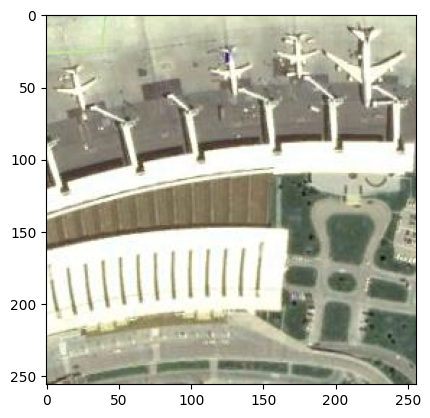

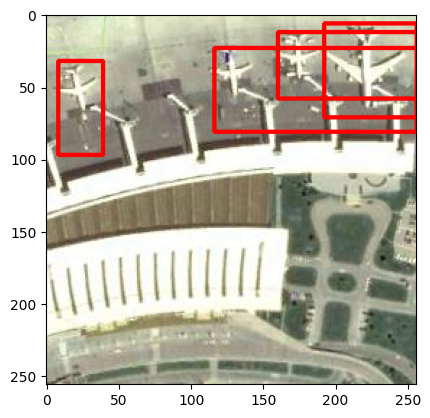

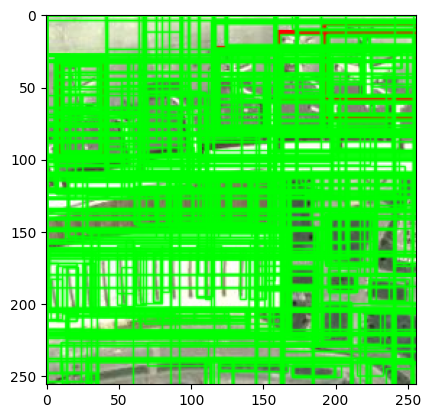

In [8]:
img_name = random.choice(images)
img = cv2.imread(os.path.join(dataset_path,img_name))
plt.imshow(img)

csv_file = os.path.join(annot,str(img_name).split(".")[0]+".csv")
boxes = get_rectangle(csv_file)

for box in boxes:
    cv2.rectangle(img,(box['x1'],box['y1'],box['x2'],box['y2']),(255,0,0),2)
plt.figure()
plt.imshow(img)

cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imout = img.copy()
for i,rect in enumerate(rects):
    x,y,w,h = rect
    cv2.rectangle(imout,(x,y),(x+w,y+h),(0,255,0),1,cv2.LINE_AA)

plt.figure()
plt.imshow(imout)

In [9]:
for file in tqdm(images[:500],desc="Creating dataset"):
    try:
        box_values=[]
        image = cv2.imread(os.path.join(dataset_path,file))
        csv_path = os.path.join(annot,file.split(".")[0]+".csv")
        box_values.extend(get_rectangle(csv_path))
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        ssresults =ss.process()
        imout = image.copy()
        counter = flag = falsecounter = fflag = bflag = 0
        for e,result in enumerate(ssresults):
            if e<max_proposal and flag==0:
                for a_box in box_values:
                    x,y,w,h = result
                    iou = get_iou(a_box,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    if counter<max_sample:
                        if iou > IOU_threshold_plane:
                            train_images.append(rectang_from_image(image,x,y,w,h))
                            train_labels.append(1)
                            counter += 1
                        else:
                            fflag = 1
                        if falsecounter < max_sample:
                            if iou<IOU_threshold_bground:
                                train_images.append(rectang_from_image(image,x,y,w,h))
                                train_labels.append(0)
                                falsecounter += 1
                            else:
                                bflag=1
                    if fflag ==1 and bflag ==1:
                        flag =1
    except Exception as e:
        print(e)
        continue
        

Creating dataset: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]


In [10]:
vggmodel = VGG16(weights='imagenet', include_top=True)

for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

X = vggmodel.layers[-2].output
predictions = Dense(1,activation="sigmoid")(X)
model_final = Model(vggmodel.input,predictions)
opt = Adam(learning_rate=0.0001)
model_final.compile(loss =keras.losses.binary_crossentropy, optimizer = opt,metrics=["accuracy"])
model_final.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
<InputLayer name=input_layer, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<MaxPooling2D name=block1_pool, built=True>
<Conv2D name=block2_conv1, built=True>
<Conv2D name=block2_conv2, built=True>
<MaxPooling2D name=block2_pool, built=True>
<Conv2D name=block3_conv1, built=True>
<Conv2D name=block3_conv2, built=True>
<Conv2D name=block3_conv3, built=True>
<MaxPooling2D name=block3_pool, built=True>
<Conv2D name=block4_conv1, built=True>
<Conv2D name=block4_conv2, built=True>
<Conv2D name=block4_conv3, built=True>
<MaxPooling2D name=block4_pool, built=True>


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,264,641 (512.18 MB)

 Trainable params: 126,629,377 (483.05 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [11]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

X_train,X_test,y_train,y_test = train_test_split(X_new,y_new,test_size=0.10)

trdata    = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=0)
traindata = trdata.flow(x=X_train,y=y_train)
tsdata    = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=0)
testdata  = tsdata.flow(x=X_test, y=y_test)

In [12]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.keras",
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto')

early = EarlyStopping(monitor='val_loss', 
                      min_delta=0,
                      patience=3,
                      verbose=1,
                      mode='auto')

hist = model_final.fit(x= traindata,
                                 steps_per_epoch= 10,
                                 epochs= 100, 
                                 validation_data= testdata,
                                 validation_steps=2,
                                 callbacks=[checkpoint,early])

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/10 ━━━━━━━━━━━━━━━━━━━━ 5:23 36s/step - accuracy: 0.4062 - loss: 0.8872

I0000 00:00:1743908623.385857     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7509 - loss: 0.9801
Epoch 1: val_loss improved from inf to 0.30368, saving model to ieeercnn_vgg16_1.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.7593 - loss: 0.9551 - val_accuracy: 0.9062 - val_loss: 0.3037
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8929 - loss: 0.3021
Epoch 2: val_loss improved from 0.30368 to 0.20017, saving model to ieeercnn_vgg16_1.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8927 - loss: 0.3051 - val_accuracy: 0.9375 - val_loss: 0.2002
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9222 - loss: 0.2470
Epoch 3: val_loss improved from 0.20017 to 0.18831, saving model to ieeercnn_vgg16_1.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9233 - loss: 0.2423 - val_accuracy: 0.8906 - val_loss: 0.1883
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9613 - loss: 0.1209
Epoch 4: val_loss did not improve from 0.18831
10/

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━

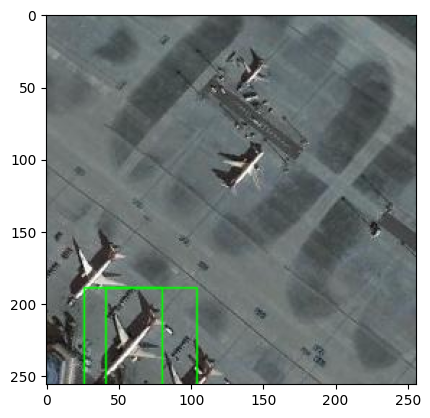

In [13]:
img=random.choice(images)
img = cv2.imread(os.path.join(dataset_path,img))
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = img.copy()
for e,result in enumerate(ssresults):
    if e < 2000:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= model_final.predict(img)
        if out[0][0] > 0.7:
            cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imout)

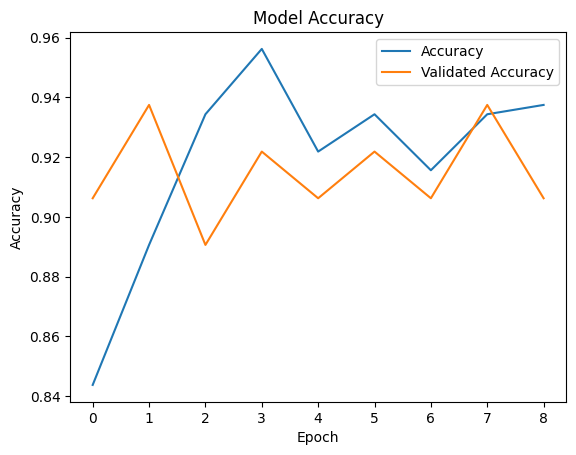

<Figure size 640x480 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validated Accuracy"])
plt.show()
plt.savefig('chart - Accruacy.png')

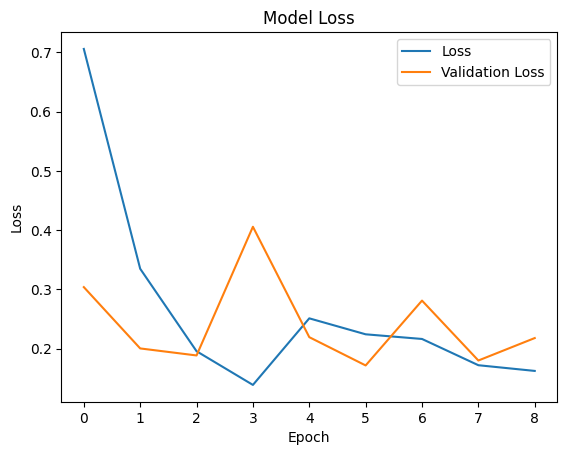

<Figure size 640x480 with 0 Axes>

In [15]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')


In [16]:
from IPython.display import HTML
def create_download_link(title = "Download Model File",filename = './RNN_model.keras'):
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

model_final.save('./RNN_model.keras')
create_download_link(filename='./RNN_model.keras')